<a href="https://colab.research.google.com/github/Samarth0709/Monte-Carlo-Simulation/blob/main/MC_SIMULATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The exclamation mark (!) tells Colab to run a terminal command
!pip install yfinance

/tmp/ipython-input-1058755291.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('^NSEI', start='2023-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed



--- STATISTICS ---
Mean Daily Log Return: 0.000727
Daily Volatility (Std Dev): 0.006187


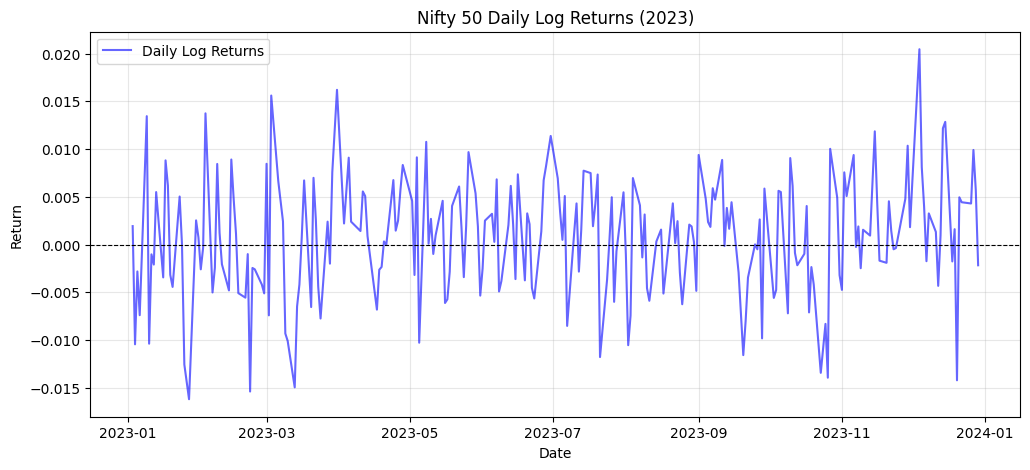


Difference between Simple and Log Returns (First 5 days):
Price      Simple_Return Log_Return
Ticker                             
Date                               
2023-01-03      0.001929   0.001927
2023-01-04     -0.010399  -0.010454
2023-01-05     -0.002815  -0.002819
2023-01-06     -0.007376  -0.007403
2023-01-09      0.013536   0.013445


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- STEP 1: DOWNLOAD DATA ---
# We use the ticker '^NSEI' for Nifty 50
print("Downloading Nifty 50 Data...")
data = yf.download('^NSEI', start='2023-01-01', end='2024-01-01')

# Keep only the 'Close' price column
# We use .copy() to avoid SettingWithCopy warnings
df = data[['Close']].copy()

# --- STEP 2: CALCULATE RETURNS ---

# A. Simple Returns (Arithmetic)
# Formula: (Price_t / Price_t-1) - 1
df['Simple_Return'] = df['Close'].pct_change()

# B. Log Returns (Geometric)
# Formula: ln(Price_t / Price_t-1)
# np.log calculates the natural logarithm
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Drop the first row (NaN) because it has no previous day to compare to
df.dropna(inplace=True)

# --- STEP 3: ANALYZE & VISUALIZE ---

print("\n--- STATISTICS ---")
print(f"Mean Daily Log Return: {df['Log_Return'].mean():.6f}")
print(f"Daily Volatility (Std Dev): {df['Log_Return'].std():.6f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Log_Return'], label='Daily Log Returns', color='blue', alpha=0.6)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--') # Zero line
plt.title('Nifty 50 Daily Log Returns (2023)')
plt.ylabel('Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize the difference (Simple vs Log)
print("\nDifference between Simple and Log Returns (First 5 days):")
print(df[['Simple_Return', 'Log_Return']].head())

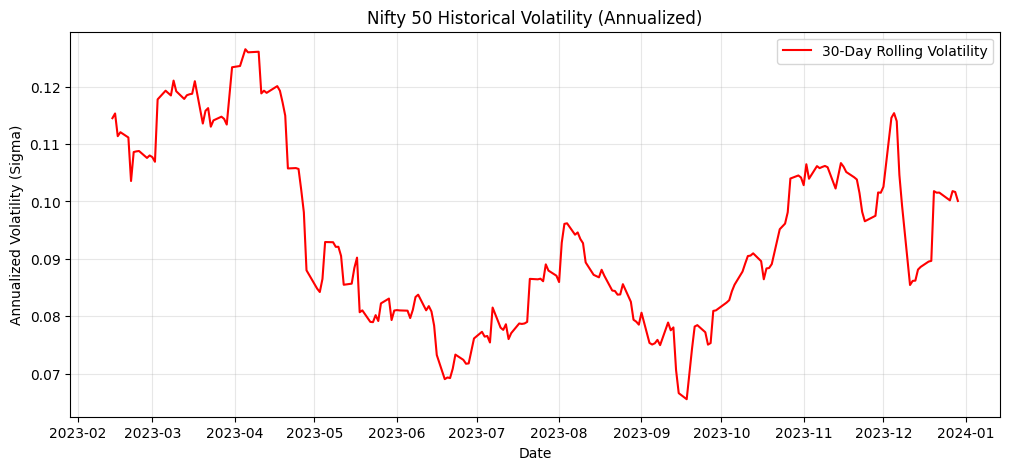

Current Annualized Volatility: 10.01%


In [ ]:
# --- DAY 2: VOLATILITY ANALYSIS ---

# 1. Define the Window (e.g., 30 Trading Days)
window_size = 30

# 2. Calculate Rolling Standard Deviation (Volatility)
# We multiply by sqrt(252) to "Annualize" it (make it comparable to interest rates)
df['Rolling_Vol'] = df['Log_Return'].rolling(window=window_size).std() * np.sqrt(252)

# 3. Plotting Historical Volatility
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Rolling_Vol'], color='red', label=f'{window_size}-Day Rolling Volatility')

plt.title('Nifty 50 Historical Volatility (Annualized)')
plt.ylabel('Annualized Volatility (Sigma)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 4. Print Current Market Risk
current_vol = df['Rolling_Vol'].iloc[-1]
print(f"Current Annualized Volatility: {current_vol*100:.2f}%")

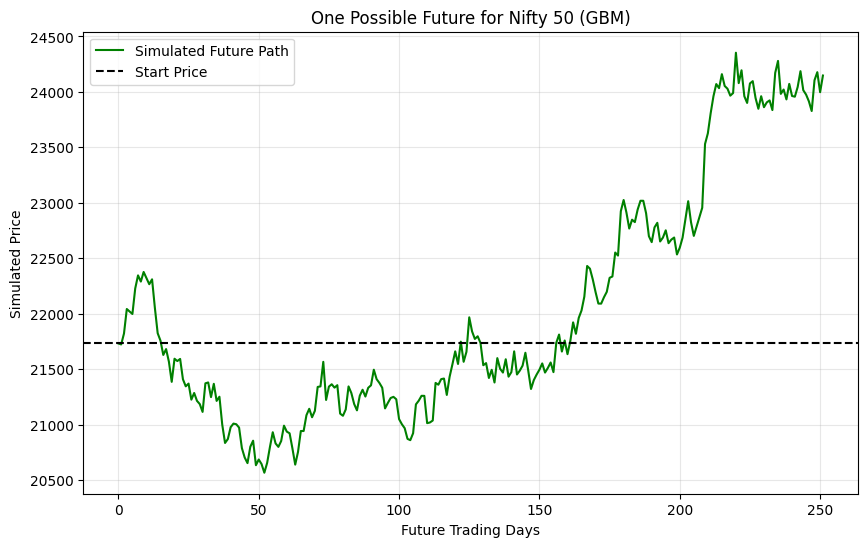

In [ ]:
# --- DAY 3: BROWNIAN MOTION SIMULATION ---

# 1. Setup Parameters (Derived from your Day 2 analysis)
S0 = df['Close'].iloc[-1].item()      # Starting Price (The last actual price of Nifty)
mu = 0.12                      # Expected Return (Assumed 12% per year)
sigma = current_vol            # Volatility (We use the last value from your graph: ~10%)
T = 1.0                        # Time horizon (1 Year)
dt = 1/252                     # Daily time step
N = int(T/dt)                  # Total steps (252 days)

# 2. Simulate ONE Path (The "Random Walk")
# Generate 252 random normal numbers (shocks)
np.random.seed(42) # For reproducibility
Z = np.random.normal(0, 1, N)

# Calculate the path using the GBM Formula
# S_t = S_0 * exp( (mu - 0.5*sigma^2)*t + sigma*sqrt(t)*Z )
drift = (mu - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt) * Z
daily_returns = np.exp(drift + diffusion)

# Create the price path
price_path = np.zeros(N)
price_path[0] = S0
for t in range(1, N):
    price_path[t] = price_path[t-1] * daily_returns[t]

# 3. Plotting
plt.figure(figsize=(10, 6))
plt.plot(price_path, color='green', label='Simulated Future Path')
plt.axhline(S0, color='black', linestyle='--', label='Start Price')
plt.title(f'One Possible Future for Nifty 50 (GBM)')
plt.xlabel('Future Trading Days')
plt.ylabel('Simulated Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Fetching data for ^NSEI...


/tmp/ipython-input-3446941058.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


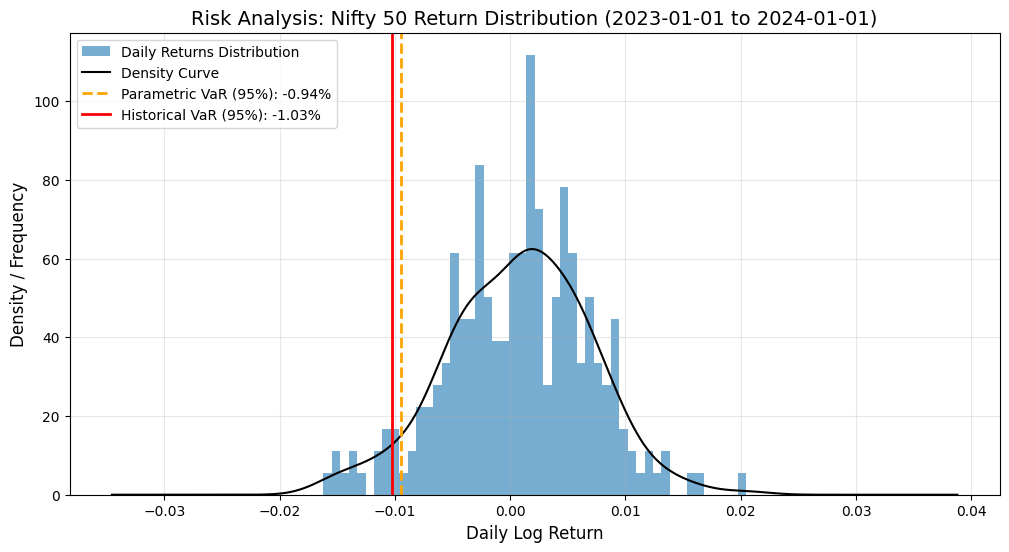


RISK REPORT: ^NSEI (Investment: Rs. 100,000.00)
Observation Period: 244 trading days
Daily Volatility:   0.62%
--------------------------------------------------
95% Parametric VaR: -0.9450%  | Loss: Rs. 945.00
95% Historical VaR: -1.0257%  | Loss: Rs. 1,025.68
--------------------------------------------------
CONDITIONAL VaR (Expected Shortfall):
Avg Loss on Bad Days: -1.2753% | Loss: Rs. 1,275.34


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import scipy.stats as stats

# --- CONFIGURATION ---
TICKER = '^NSEI'       # Nifty 50
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
CONFIDENCE_LEVEL = 0.95
PORTFOLIO_VALUE = 100000  # Rs. 1,00,000 invested

# --- STEP 1: DATA PIPELINE ---
print(f"Fetching data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
df = data[['Close']].copy()

# Calculate Log Returns: ln(Pt / Pt-1)
# Log returns are preferred for risk modeling due to time-additivity
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

# --- STEP 2: PARAMETRIC VaR (The "Normal" Method) ---
# Assumption: Returns follow a Gaussian (Normal) Distribution
mu = df['Log_Return'].mean()
sigma = df['Log_Return'].std()

# Calculate Z-score for 5% cutoff (approx -1.645)
z_score = stats.norm.ppf(1 - CONFIDENCE_LEVEL)

# Parametric VaR Formula: (mu + z * sigma)
var_param_pct = mu + (z_score * sigma)
var_param_inr = PORTFOLIO_VALUE * var_param_pct

# --- STEP 3: HISTORICAL VaR (The "Real-World" Method) ---
# No assumptions; we let the past data speak for itself
# We simply find the 5th percentile of actual past returns
var_hist_pct = np.percentile(df['Log_Return'], (1 - CONFIDENCE_LEVEL) * 100)
var_hist_inr = PORTFOLIO_VALUE * var_hist_pct

# --- BONUS: EXPECTED SHORTFALL (CVaR) ---
# "If we DO cross the VaR threshold, how bad will the crash be?"
# This is the average of all returns worse than the VaR
cvar_hist_pct = df[df['Log_Return'] <= var_hist_pct]['Log_Return'].mean()
cvar_hist_inr = PORTFOLIO_VALUE * cvar_hist_pct

# --- STEP 4: VISUALIZATION ---
plt.figure(figsize=(12, 6))

# 1. The Distribution (Histogram)
# Bins=50 gives us a granular view of the "Fat Tails"
plt.hist(df['Log_Return'], bins=50, density=True, alpha=0.6, color='#1f77b4', label='Daily Returns Distribution')

# 2. The Density Curve (KDE)
# This smooth line shows the "shape" of the market
df['Log_Return'].plot(kind='kde', color='black', linewidth=1.5, label='Density Curve')

# 3. The Risk Thresholds
plt.axvline(var_param_pct, color='orange', linestyle='--', linewidth=2, label=f'Parametric VaR (95%): {var_param_pct:.2%}')
plt.axvline(var_hist_pct, color='red', linestyle='-', linewidth=2, label=f'Historical VaR (95%): {var_hist_pct:.2%}')

# Formatting
plt.title(f'Risk Analysis: Nifty 50 Return Distribution ({START_DATE} to {END_DATE})', fontsize=14)
plt.xlabel('Daily Log Return', fontsize=12)
plt.ylabel('Density / Frequency', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

# --- STEP 5: PROFESSIONAL REPORTING ---
print("\n" + "="*50)
print(f"RISK REPORT: {TICKER} (Investment: Rs. {PORTFOLIO_VALUE:,.2f})")
print("="*50)
print(f"Observation Period: {len(df)} trading days")
print(f"Daily Volatility:   {sigma:.2%}")
print("-" * 50)
print(f"95% Parametric VaR: {var_param_pct:.4%}  | Loss: Rs. {abs(var_param_inr):,.2f}")
print(f"95% Historical VaR: {var_hist_pct:.4%}  | Loss: Rs. {abs(var_hist_inr):,.2f}")
print("-" * 50)
print(f"CONDITIONAL VaR (Expected Shortfall):")
print(f"Avg Loss on Bad Days: {cvar_hist_pct:.4%} | Loss: Rs. {abs(cvar_hist_inr):,.2f}")
print("="*50)

1. Fetching data for ^NSEI...


/tmp/ipython-input-1399117350.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


2. Model Parameters:
   Start Price (S0): 21731.40
   Annual Drift (μ): 18.33%
   Annual Volatility (σ): 9.82%


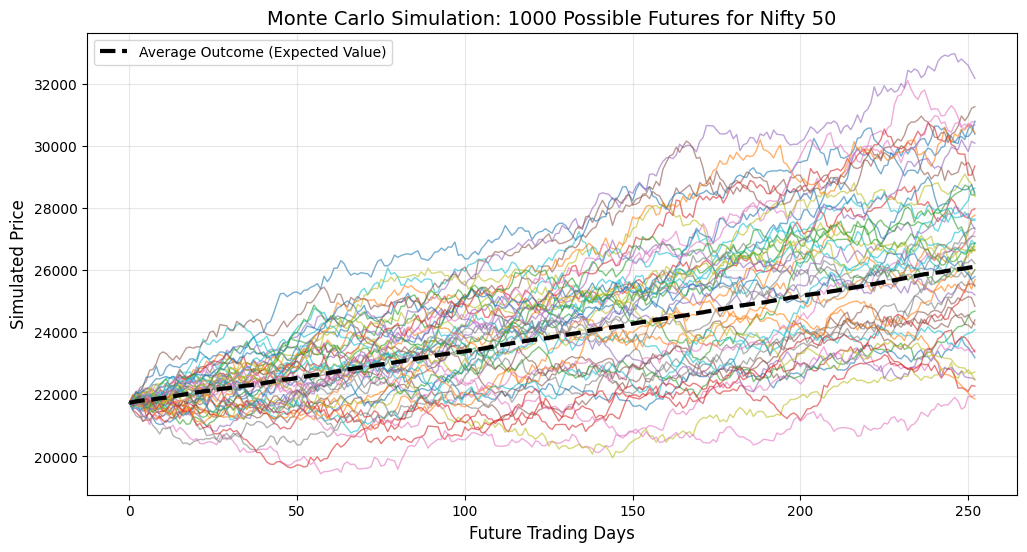


SIMULATION RESULTS (1 Year Forecast)
Probability of Profit: 96.6%
Expected Price (Avg):  26108.89
----------------------------------------
Optimistic Case (Top 5%): 30607.44
Pessimistic Case (Bottom 5%): 22116.54


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
TICKER = '^NSEI'        # Nifty 50
SIMULATIONS = 1000      # Number of "Alternate Universes" to simulate
TIME_HORIZON = 252      # Days to simulate (1 Year)
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'

# --- STEP 1: GET HISTORICAL DATA ---
print(f"1. Fetching data for {TICKER}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)
df = data[['Close']].copy()

# Calculate Log Returns
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)

# --- STEP 2: ESTIMATE PARAMETERS (Drift & Volatility) ---
# We estimate the model parameters from history
mu = df['Log_Return'].mean() * 252      # Annualized Drift (Return)
sigma = df['Log_Return'].std() * (252**0.5) # Annualized Volatility
S0 = df['Close'].iloc[-1].item()        # Starting Price (Last actual close)

print(f"2. Model Parameters:")
print(f"   Start Price (S0): {S0:.2f}")
print(f"   Annual Drift (μ): {mu:.2%}")
print(f"   Annual Volatility (σ): {sigma:.2%}")

# --- STEP 3: THE MONTE CARLO ENGINE (Vectorized GBM) ---
# We simulate 1000 paths at once using Matrix Math (Faster than loops!)

# A. Define Time Steps
dt = 1/252  # 1 Day step

# B. Generate Random Shocks (The "Wiener Process")
# We create a matrix of size [Days, Simulations] filled with random Z-scores
np.random.seed(42) # For reproducibility
Z_matrix = np.random.normal(0, 1, (TIME_HORIZON, SIMULATIONS))

# C. Apply the Geometric Brownian Motion Formula
# Formula: Returns = (mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z
drift_term = (mu - 0.5 * sigma**2) * dt
diffusion_term = sigma * (dt**0.5) * Z_matrix

# Calculate Daily Returns for all 1000 paths at once
daily_log_returns = drift_term + diffusion_term

# D. Convert Returns to Price Paths
# We use cumulative sum (cumsum) to add up returns over time
cumulative_returns = np.cumsum(daily_log_returns, axis=0)
cumulative_returns = np.vstack([np.zeros((1, SIMULATIONS)), cumulative_returns]) # Add Day 0 (0% return)

# S_t = S_0 * exp(Sum of Returns)
price_paths = S0 * np.exp(cumulative_returns)

# --- STEP 4: VISUALIZATION (The Cone of Uncertainty) ---
plt.figure(figsize=(12, 6))

# Plot the first 50 paths (plotting all 1000 makes it messy)
plt.plot(price_paths[:, :50], lw=1, alpha=0.6)

# Plot the "Mean Path" (The average of all 1000 futures)
mean_path = np.mean(price_paths, axis=1)
plt.plot(mean_path, color='black', linewidth=3, linestyle='--', label='Average Outcome (Expected Value)')

plt.title(f'Monte Carlo Simulation: {SIMULATIONS} Possible Futures for Nifty 50', fontsize=14)
plt.xlabel('Future Trading Days', fontsize=12)
plt.ylabel('Simulated Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- STEP 5: PROBABILISTIC ANALYSIS ---
# Now we can answer questions like "What is the chance Nifty crosses 25k?"
final_prices = price_paths[-1, :] # The prices on the very last day

prob_profit = np.mean(final_prices > S0)
worst_case = np.percentile(final_prices, 5) # 5th Percentile (95% VaR)
best_case = np.percentile(final_prices, 95) # 95th Percentile

print("\n" + "="*40)
print("SIMULATION RESULTS (1 Year Forecast)")
print("="*40)
print(f"Probability of Profit: {prob_profit:.1%}")
print(f"Expected Price (Avg):  {np.mean(final_prices):.2f}")
print("-" * 40)
print(f"Optimistic Case (Top 5%): {best_case:.2f}")
print(f"Pessimistic Case (Bottom 5%): {worst_case:.2f}")
print("="*40)

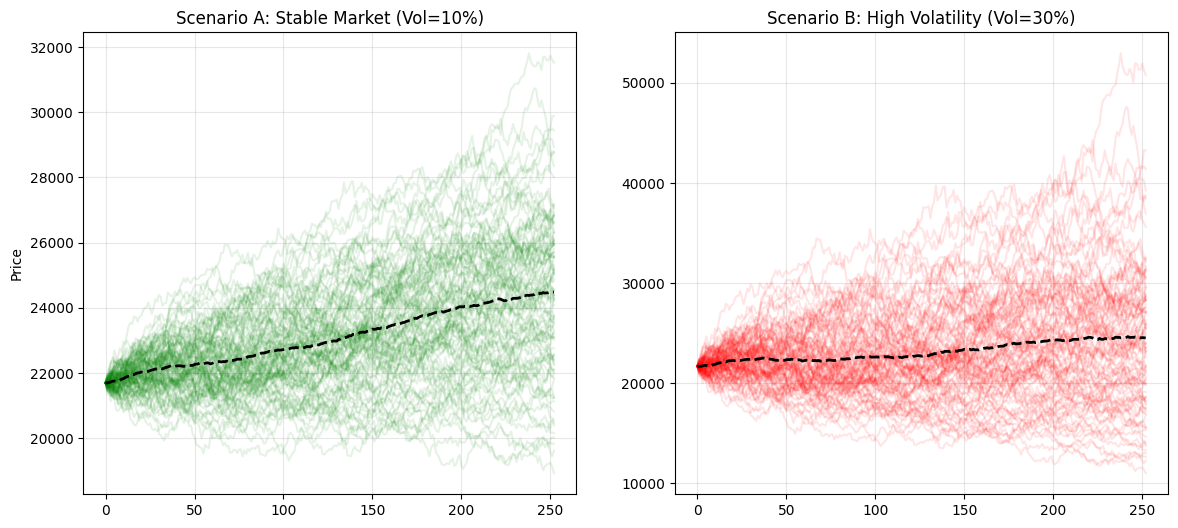

Day 6 Task Complete: GBM Function Implemented and Tested.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- DAY 6: IMPLEMENTING THE GBM ENGINE ---

def simulate_gbm(S0, mu, sigma, T, dt, n_sims, seed=42):
    """
    Simulates Geometric Brownian Motion (GBM) price paths.

    Parameters:
    S0 (float): Initial stock price
    mu (float): Annualized drift (expected return)
    sigma (float): Annualized volatility
    T (float): Time horizon in years
    dt (float): Time step size (e.g., 1/252)
    n_sims (int): Number of paths to simulate
    seed (int): Random seed for reproducibility

    Returns:
    np.array: Matrix of price paths with shape (n_steps + 1, n_sims)
    """
    # 1. Set Seed (Crucial for reproducibility in research)
    np.random.seed(seed)

    # 2. Calculate Steps
    N = int(T / dt)

    # 3. Generate Random Matrix (Vectorized Wiener Process)
    # We generate (N x n_sims) random shocks at once
    Z = np.random.normal(0, 1, (N, n_sims))

    # 4. Apply GBM Formula
    # Drift Term: Deterministic trend minus volatility drag
    drift = (mu - 0.5 * sigma**2) * dt

    # Diffusion Term: Scaled random shocks
    diffusion = sigma * np.sqrt(dt) * Z

    # 5. Compute Price Path
    # daily_log_returns = drift + diffusion
    daily_returns = np.exp(drift + diffusion)

    # We start with a row of 1s (representing the starting multiplier)
    # Then we accumulate the products
    price_paths = np.zeros((N + 1, n_sims))
    price_paths[0] = S0

    # Efficient Cumulative Product (cumprod)
    # Instead of a loop, we multiply all returns cumulatively
    price_paths[1:] = S0 * np.cumprod(daily_returns, axis=0)

    return price_paths

# --- TESTING THE FUNCTION (Scenario Analysis) ---

# Define Parameters (Based on your Nifty 50 analysis)
current_price = 21700 # Example Price
mu_base = 0.12        # 12% Expected Return

# Run Simulation 1: Low Volatility (Stable Market)
paths_stable = simulate_gbm(S0=current_price, mu=mu_base, sigma=0.10, T=1, dt=1/252, n_sims=100)

# Run Simulation 2: High Volatility (Panic Market)
paths_panic = simulate_gbm(S0=current_price, mu=mu_base, sigma=0.30, T=1, dt=1/252, n_sims=100)

# --- VISUALIZATION ---
plt.figure(figsize=(14, 6))

# Plot Stable Market
plt.subplot(1, 2, 1)
plt.plot(paths_stable, color='green', alpha=0.1)
plt.plot(paths_stable.mean(axis=1), color='black', linewidth=2, linestyle='--')
plt.title('Scenario A: Stable Market (Vol=10%)')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)

# Plot Panic Market
plt.subplot(1, 2, 2)
plt.plot(paths_panic, color='red', alpha=0.1)
plt.plot(paths_panic.mean(axis=1), color='black', linewidth=2, linestyle='--')
plt.title('Scenario B: High Volatility (Vol=30%)')
plt.grid(True, alpha=0.3)

plt.show()

print("Day 6 Task Complete: GBM Function Implemented and Tested.")

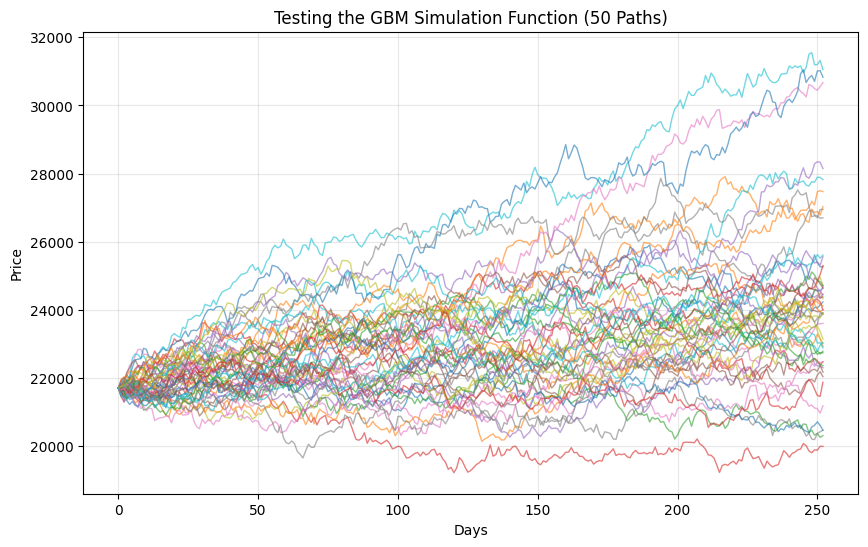

Function Test Complete. Generated 50 paths over 252 days.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- DAY 6: IMPLEMENTING THE GBM FUNCTION ---

def GBM_simulation(S0, mu, sigma, T, dt, n_sims):
    """
    A simple function to simulate Geometric Brownian Motion price paths.
    """
    # 1. Setup
    N = int(T / dt) # Number of time steps
    np.random.seed(42) # Ensure we get the same random numbers every time

    # 2. Generate Random Shocks (The 'Z' values)
    # We generate a matrix of random numbers [Time Steps x Number of Simulations]
    Z = np.random.normal(0, 1, (N, n_sims))

    # 3. Apply the Formula
    # Drift = (mu - 0.5 * sigma^2) * dt
    drift = (mu - 0.5 * sigma**2) * dt

    # Diffusion = sigma * sqrt(dt) * Z
    diffusion = sigma * np.sqrt(dt) * Z

    # Calculate Daily Returns
    daily_returns = np.exp(drift + diffusion)

    # 4. Construct Price Paths
    # Start with a matrix of zeros
    price_paths = np.zeros((N + 1, n_sims))
    price_paths[0] = S0

    # Calculate future prices
    # We use cumulative product because returns compound over time
    price_paths[1:] = S0 * np.cumprod(daily_returns, axis=0)

    return price_paths

# --- TESTING THE FUNCTION ---
# We test it with the Nifty 50 parameters we found earlier
current_price = 21700  # Example S0
mu_nifty = 0.12        # Example Drift
sigma_nifty = 0.10     # Example Volatility (10%)

# Call the function
simulated_paths = GBM_simulation(S0=current_price, mu=mu_nifty, sigma=sigma_nifty, T=1, dt=1/252, n_sims=50)

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(simulated_paths, lw=1, alpha=0.6)
plt.title('Testing the GBM Simulation Function (50 Paths)')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Function Test Complete. Generated {simulated_paths.shape[1]} paths over {simulated_paths.shape[0]-1} days.")

Pricing European Call Option:
Spot: 21700 | Strike: 22000 | Risk-Free Rate: 7% | Vol: 10%


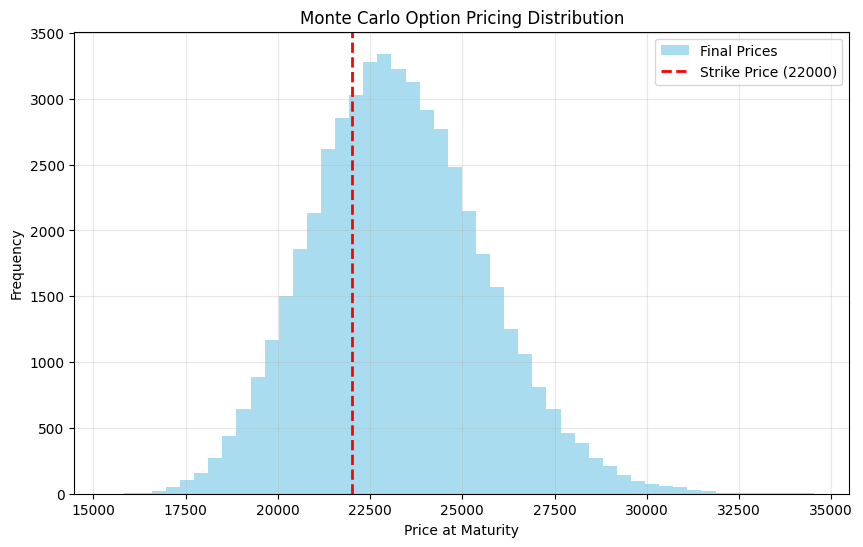

----------------------------------------
Calculated Call Option Price: Rs. 1561.98
----------------------------------------
Probability of Profit (ITM):  69.52%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- DAY 7: MONTE CARLO OPTION PRICING (European Call) ---

# 1. SETUP PARAMETERS (Risk-Neutral Inputs)
S0 = 21700          # Current Price of Nifty 50
K = 22000           # Strike Price (Target Price)
r = 0.07            # Risk-Free Rate (7% - e.g., India 10Y Bond)
sigma = 0.10        # Volatility (10%)
T = 1.0             # Time Horizon (1 Year)
dt = 1/252          # Time Step
N = int(T/dt)       # Total Steps
M = 50000           # Number of Simulations (High M for accuracy)

print(f"Pricing European Call Option:")
print(f"Spot: {S0} | Strike: {K} | Risk-Free Rate: {r:.0%} | Vol: {sigma:.0%}")

# 2. GENERATE PRICE PATHS (Vectorized)
np.random.seed(42)
Z = np.random.normal(0, 1, (N, M))

# Risk-Neutral Drift: (r - 0.5 * sigma^2)
drift = (r - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt) * Z
daily_returns = np.exp(drift + diffusion)

# Calculate Terminal Price (ST) only
# Optimization: We use cumprod just to get the final multiplier
total_growth = np.prod(daily_returns, axis=0)
ST = S0 * total_growth

# 3. CALCULATE PAYOFF
# Call Payoff = max(ST - K, 0)
payoffs = np.maximum(ST - K, 0)

# 4. DISCOUNT TO PRESENT VALUE
# Price = Average Payoff * e^(-rT)
mean_payoff = np.mean(payoffs)
option_price = mean_payoff * np.exp(-r * T)

# 5. VISUALIZATION
plt.figure(figsize=(10, 6))
# Filter out zero payoffs for a clearer histogram
profitable_outcomes = ST[ST > K]
plt.hist(ST, bins=50, color='skyblue', alpha=0.7, label='Final Prices')
plt.axvline(K, color='red', linestyle='--', linewidth=2, label=f'Strike Price ({K})')
plt.title('Monte Carlo Option Pricing Distribution')
plt.xlabel('Price at Maturity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. RESULTS
print("-" * 40)
print(f"Calculated Call Option Price: Rs. {option_price:.2f}")
print("-" * 40)
print(f"Probability of Profit (ITM):  {np.mean(ST > K)*100:.2f}%")

Pricing European PUT Option:
S0: 21700 | Strike: 21500 | Risk-Free Rate: 7% | Vol: 10%
Simulations: 50000


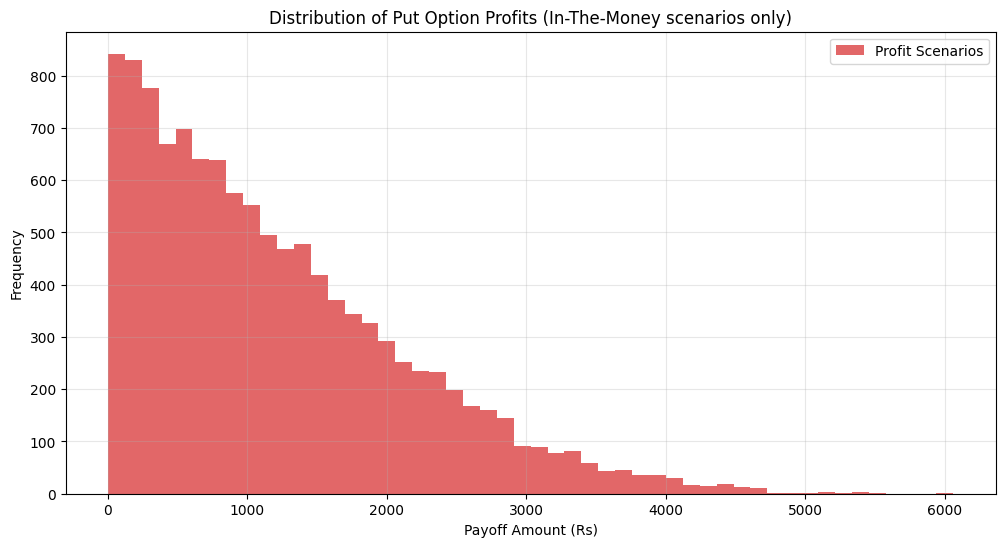

--------------------------------------------------
MONTE CARLO PRICING RESULTS
--------------------------------------------------
Put Option Price:   Rs. 257.05
Standard Error:     Rs. 2.8321
95% Conf Interval:  [Rs. 251.50, Rs. 262.60]
--------------------------------------------------
Analysis:
The simulation is 95% confident that the true price lies between
251.50 and 262.60. To make this range tighter,
we would need to increase the number of simulations (M).
--------------------------------------------------


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- DAY 8: PRICING A PUT OPTION WITH CONFIDENCE INTERVALS ---

# 1. SETUP PARAMETERS (Risk-Neutral World)
S0 = 21700          # Current Nifty 50 Price
K = 21500           # Strike Price (We profit if market falls below this)
r = 0.07            # Risk-Free Rate (7%)
sigma = 0.10        # Volatility (10%)
T = 1.0             # Time Horizon (1 Year)
dt = 1/252          # Time Step
N = int(T/dt)       # Steps
M = 50000           # Simulations (Higher M = Smaller Confidence Interval)

print(f"Pricing European PUT Option:")
print(f"S0: {S0} | Strike: {K} | Risk-Free Rate: {r:.0%} | Vol: {sigma:.0%}")
print(f"Simulations: {M}")

# 2. VECTORIZED SIMULATION
np.random.seed(42)
Z = np.random.normal(0, 1, (N, M))

# Risk-Neutral GBM Formula
drift = (r - 0.5 * sigma**2) * dt
diffusion = sigma * np.sqrt(dt) * Z
daily_returns = np.exp(drift + diffusion)

# Calculate Terminal Prices only (Optimization: We don't need the whole path for pricing)
# We can just multiply all returns to jump to the end
total_returns = np.prod(daily_returns, axis=0)
ST = S0 * total_returns

# 3. CALCULATE PUT PAYOFF
# Put Payoff = max(Strike - S_T, 0) -> Profit when S_T is LOW
payoffs = np.maximum(K - ST, 0)

# Discount back to present value
discounted_payoffs = payoffs * np.exp(-r * T)

# 4. STATISTICS & CONFIDENCE INTERVALS
# Standard Error = StdDev / sqrt(M)
option_price = np.mean(discounted_payoffs)
std_error = np.std(discounted_payoffs) / np.sqrt(M)

# 95% Confidence Interval (Z-score = 1.96)
ci_lower = option_price - (1.96 * std_error)
ci_upper = option_price + (1.96 * std_error)

# 5. VISUALIZATION
plt.figure(figsize=(12, 6))

# Histogram of Positive Payoffs (Ignoring the zeros makes the graph easier to read)
positive_payoffs = payoffs[payoffs > 0]
plt.hist(positive_payoffs, bins=50, color='#d62728', alpha=0.7, label='Profit Scenarios')

plt.title(f'Distribution of Put Option Profits (In-The-Money scenarios only)')
plt.xlabel('Payoff Amount (Rs)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. PROFESSIONAL REPORT
print("-" * 50)
print(f"MONTE CARLO PRICING RESULTS")
print("-" * 50)
print(f"Put Option Price:   Rs. {option_price:.2f}")
print(f"Standard Error:     Rs. {std_error:.4f}")
print(f"95% Conf Interval:  [Rs. {ci_lower:.2f}, Rs. {ci_upper:.2f}]")
print("-" * 50)
print(f"Analysis:")
print(f"The simulation is 95% confident that the true price lies between")
print(f"{ci_lower:.2f} and {ci_upper:.2f}. To make this range tighter,")
print(f"we would need to increase the number of simulations (M).")
print("-" * 50)

Simulations     MC Price        BS Price        Error          
------------------------------------------------------------
100             1314.47         1565.03         250.5632       
1000            1570.79         1565.03         5.7629         
5000            1571.61         1565.03         6.5792         
10000           1563.88         1565.03         1.1519         
50000           1564.86         1565.03         0.1701         
100000          1567.41         1565.03         2.3860         


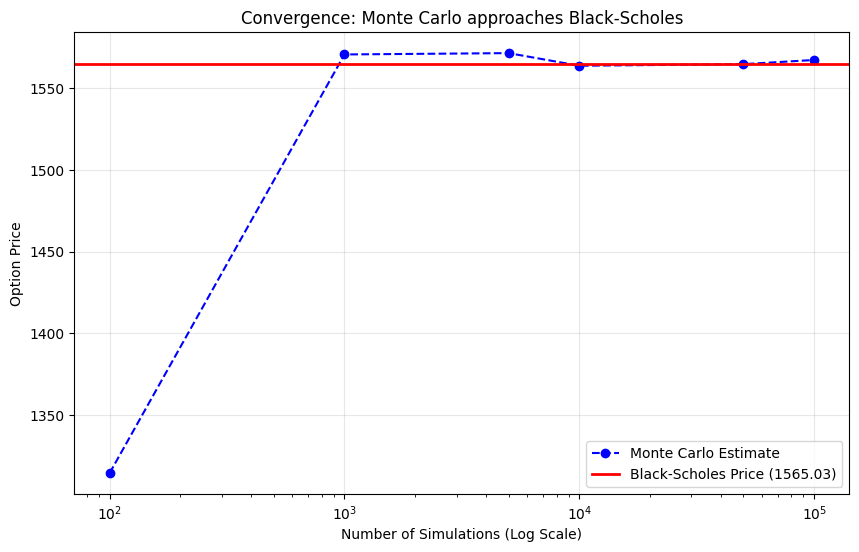


Conclusion:
With 100000 simulations, the difference is only Rs. 2.3860.


In [ ]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# --- DAY 9: MONTE CARLO vs. BLACK-SCHOLES FORMULA ---

# 1. SETUP PARAMETERS
S0 = 21700          # Current Price
K = 22000           # Strike Price (Call Option)
T = 1.0             # Time (1 Year)
r = 0.07            # Risk-Free Rate (7%)
sigma = 0.10        # Volatility (10%)

# 2. METHOD A: BLACK-SCHOLES FORMULA (The "Exact" Analytical Solution)
# Formula: C = S*N(d1) - K*e^(-rT)*N(d2)
def black_scholes_call(S, K, T, r, sigma):
    # d1 and d2 are the probability factors
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    # N(x) is the Cumulative Normal Distribution Function
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) -
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    return call_price

bs_price = black_scholes_call(S0, K, T, r, sigma)

# 3. METHOD B: MONTE CARLO SIMULATION (The "Approximation")
# We run simulations with increasing sizes to show convergence
sim_sizes = [100, 1000, 5000, 10000, 50000, 100000]
mc_prices = []
errors = []

print(f"{'Simulations':<15} {'MC Price':<15} {'BS Price':<15} {'Error':<15}")
print("-" * 60)

for M in sim_sizes:
    # Quick Vectorized Monte Carlo
    np.random.seed(42) # Consistent Randomness
    Z = np.random.normal(0, 1, M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    payoffs = np.maximum(ST - K, 0)
    mc_price = np.mean(payoffs) * np.exp(-r * T)

    mc_prices.append(mc_price)
    error = abs(mc_price - bs_price)
    errors.append(error)

    print(f"{M:<15} {mc_price:<15.2f} {bs_price:<15.2f} {error:<15.4f}")

# 4. VISUALIZATION OF CONVERGENCE
plt.figure(figsize=(10, 6))

# Plot the Monte Carlo Estimates (Blue Dots)
plt.plot(sim_sizes, mc_prices, marker='o', linestyle='--', color='blue', label='Monte Carlo Estimate')

# Plot the True Black-Scholes Price (Red Line)
plt.axhline(bs_price, color='red', linewidth=2, label=f'Black-Scholes Price ({bs_price:.2f})')

plt.xscale('log') # Use Log scale because we jump from 100 to 100,000
plt.title('Convergence: Monte Carlo approaches Black-Scholes')
plt.xlabel('Number of Simulations (Log Scale)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\nConclusion:")
print(f"With {sim_sizes[-1]} simulations, the difference is only Rs. {errors[-1]:.4f}.")

Comparison: Standard vs. Antithetic Sampling (M=50000)
------------------------------------------------------------
Method               Price           Standard Error (Noise)   
------------------------------------------------------------
Standard MC          1564.8582       7.6580                   
Antithetic MC        1563.6286       3.9979                   
------------------------------------------------------------

SUCCESS: Antithetic Sampling reduced error by 47.8%
This means we got a more precise answer without needing more data!


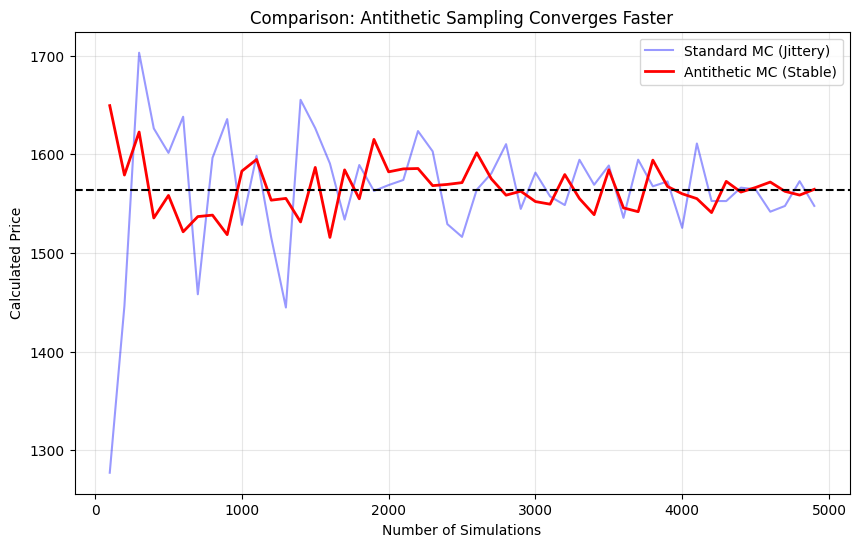

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- DAY 10: VARIANCE REDUCTION (ANTITHETIC SAMPLING) ---

# 1. SETUP PARAMETERS
S0 = 21700          # Current Price
K = 22000           # Strike Price (Call Option)
T = 1.0             # Time (1 Year)
r = 0.07            # Risk-Free Rate
sigma = 0.10        # Volatility
M = 50000           # Number of Simulations

print(f"Comparison: Standard vs. Antithetic Sampling (M={M})")
print("-" * 60)

# 2. METHOD A: STANDARD MONTE CARLO (The Baseline)
np.random.seed(42)
Z_standard = np.random.normal(0, 1, M)

ST_standard = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_standard)
payoffs_standard = np.maximum(ST_standard - K, 0)
price_standard = np.mean(payoffs_standard) * np.exp(-r * T)

# Standard Error (Noise Level)
se_standard = np.std(payoffs_standard * np.exp(-r * T)) / np.sqrt(M)


# 3. METHOD B: ANTITHETIC SAMPLING (The Advanced Way)
# We only need HALF the random numbers because we reuse them
np.random.seed(42)
Z_antithetic = np.random.normal(0, 1, int(M / 2))

# Path 1: Use +Z (The Normal Path)
ST_1 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_antithetic)

# Path 2: Use -Z (The Mirror Path) - This is the "Antithetic" trick!
ST_2 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * (-Z_antithetic))

# Calculate Payoffs for both
payoff_1 = np.maximum(ST_1 - K, 0)
payoff_2 = np.maximum(ST_2 - K, 0)

# Average the pair BEFORE taking the total average
# This pair (A + B)/2 is very stable
pair_average = (payoff_1 + payoff_2) / 2
price_antithetic = np.mean(pair_average) * np.exp(-r * T)

# Standard Error of the PAIRS
se_antithetic = np.std(pair_average * np.exp(-r * T)) / np.sqrt(int(M / 2))


# 4. RESULTS COMPARISON
variance_reduction = 1 - (se_antithetic / se_standard)

print(f"{'Method':<20} {'Price':<15} {'Standard Error (Noise)':<25}")
print("-" * 60)
print(f"{'Standard MC':<20} {price_standard:<15.4f} {se_standard:<25.4f}")
print(f"{'Antithetic MC':<20} {price_antithetic:<15.4f} {se_antithetic:<25.4f}")
print("-" * 60)
print(f"\nSUCCESS: Antithetic Sampling reduced error by {variance_reduction:.1%}")
print(f"This means we got a more precise answer without needing more data!")

# 5. VISUALIZATION OF CONVERGENCE
# Let's show how fast they stabilize
sim_sizes = range(100, 5000, 100)
std_prices = []
anti_prices = []

for m in sim_sizes:
    # Standard
    z = np.random.normal(0, 1, m)
    st = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    p = np.mean(np.maximum(st - K, 0)) * np.exp(-r * T)
    std_prices.append(p)

    # Antithetic
    z = np.random.normal(0, 1, int(m/2))
    st1 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * z)
    st2 = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * -z)
    p = np.mean((np.maximum(st1 - K, 0) + np.maximum(st2 - K, 0))/2) * np.exp(-r * T)
    anti_prices.append(p)

plt.figure(figsize=(10, 6))
plt.plot(sim_sizes, std_prices, color='blue', alpha=0.4, label='Standard MC (Jittery)')
plt.plot(sim_sizes, anti_prices, color='red', linewidth=2, label='Antithetic MC (Stable)')
plt.axhline(price_antithetic, color='black', linestyle='--')
plt.title('Comparison: Antithetic Sampling Converges Faster')
plt.xlabel('Number of Simulations')
plt.ylabel('Calculated Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/tmp/ipython-input-819243351.py:19: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

--------------------------------------------------
SHANNON ENTROPY ANALYSIS (2023-01-01 to 2024-01-01)
--------------------------------------------------
Number of Trading Days: 244
Number of Bins Used:    50
--------------------------------------------------
Shannon Entropy (H):    4.9751 bits
Max Possible Entropy:   5.6439 bits
Market Efficiency:      88.15%
--------------------------------------------------
INTERPRETATION: Lower Entropy. Market shows structure/clustering.


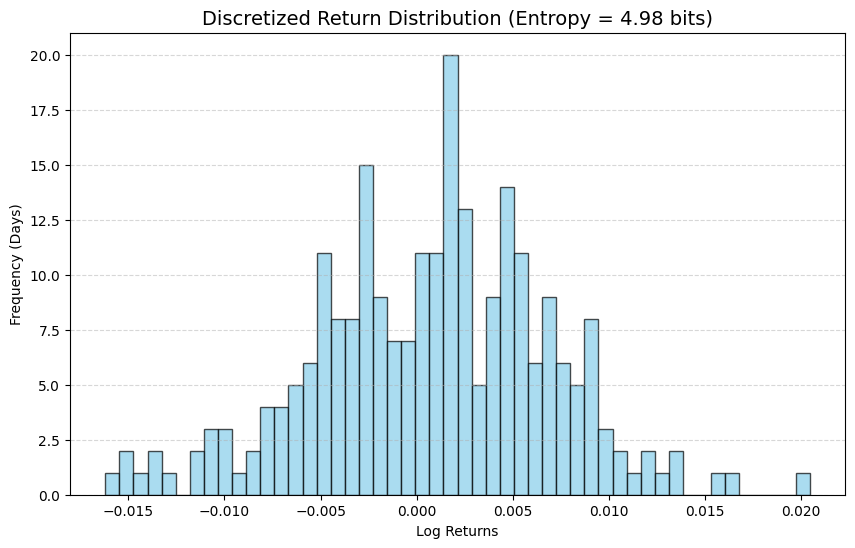

In [ ]:
# ---------------------------------------------------------
# WEEK 3: INFORMATION THEORETIC METHODS
# DAY 11: SHANNON ENTROPY OF NIFTY 50 RETURNS
# ---------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. DOWNLOAD DATA
# ---------------------------------------------------------
ticker = "^NSEI"  # Nifty 50 Ticker
start_date = "2023-01-01"
end_date = "2024-01-01"

print(f"Downloading data for {ticker}...")
data = yf.download(ticker, start=start_date, end=end_date)

# Calculate Log Returns (standard for entropy analysis)
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# 2. DISCRETIZATION (BINNING)
# ---------------------------------------------------------
# Entropy requires discrete states (bins).
# We convert continuous returns into a histogram.
num_bins = 50  # Dividing the returns into 50 distinct "buckets"

# np.histogram returns the frequency count (counts) and the bin edges
counts, bin_edges = np.histogram(data['Log_Ret'], bins=num_bins, density=False)

# 3. CALCULATE PROBABILITIES (p(x))
# ---------------------------------------------------------
# Probability = Count in Bin / Total Days
probabilities = counts / np.sum(counts)

# Remove zero probabilities to avoid log(0) error
# (In math, 0*log(0) is 0, but in code it causes NaN)
probabilities = probabilities[probabilities > 0]

# 4. CALCULATE SHANNON ENTROPY (H)
# ---------------------------------------------------------
# Formula: H(X) = - sum( p(x) * log2( p(x) ) )
shannon_entropy = -np.sum(probabilities * np.log2(probabilities))

# Maximum Possible Entropy (Uniform Distribution)
max_entropy = np.log2(num_bins)

# Efficiency Ratio (How random is the market?)
efficiency = shannon_entropy / max_entropy

# 5. OUTPUT RESULTS
# ---------------------------------------------------------
print("-" * 50)
print(f"SHANNON ENTROPY ANALYSIS ({start_date} to {end_date})")
print("-" * 50)
print(f"Number of Trading Days: {len(data)}")
print(f"Number of Bins Used:    {num_bins}")
print("-" * 50)
print(f"Shannon Entropy (H):    {shannon_entropy:.4f} bits")
print(f"Max Possible Entropy:   {max_entropy:.4f} bits")
print(f"Market Efficiency:      {efficiency:.2%}")
print("-" * 50)

# Interpretation
if efficiency > 0.9:
    print("INTERPRETATION: High Entropy. Market is very random (Efficient).")
else:
    print("INTERPRETATION: Lower Entropy. Market shows structure/clustering.")

# 6. VISUALIZATION
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.hist(data['Log_Ret'], bins=num_bins, color='skyblue', edgecolor='black', alpha=0.7)
plt.title(f"Discretized Return Distribution (Entropy = {shannon_entropy:.2f} bits)", fontsize=14)
plt.xlabel("Log Returns")
plt.ylabel("Frequency (Days)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

/tmp/ipython-input-2037480521.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


------------------------------------------------------------
RENYI ENTROPY ANALYSIS (Spectrum of Risk)
------------------------------------------------------------
Alpha = 0.5  : 5.1750 bits  (Focus on Rare Events/Tails)
Alpha = 1  : 4.9751 bits  (Shannon / Balanced)
Alpha = 2  : 4.7029 bits  (Collision / Stability)
------------------------------------------------------------
Risk Spectrum Gap (H_0.5 - H_2): 0.4721 bits
CONCLUSION: Small Gap -> Market behaves closer to a Normal Distribution.
------------------------------------------------------------


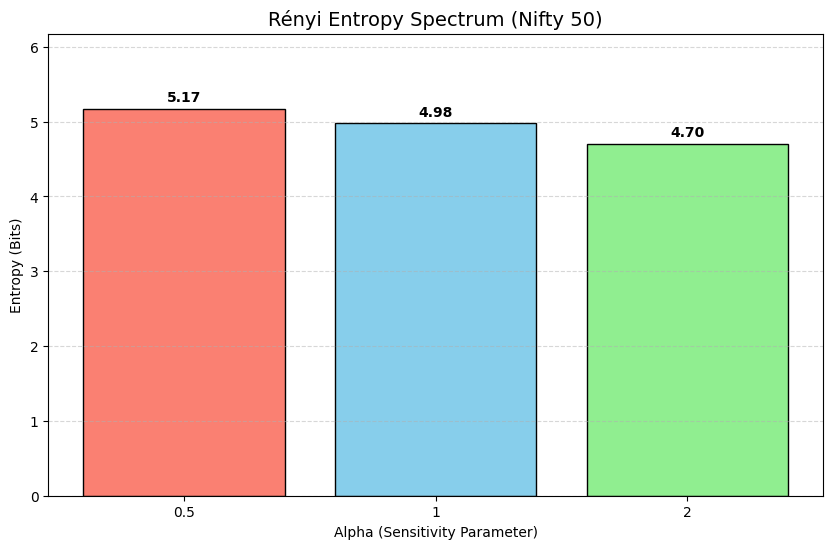

In [ ]:
# ---------------------------------------------------------
# WEEK 3: INFORMATION THEORETIC METHODS
# DAY 12: RENYI ENTROPY (The Spectrum of Risk)
# ---------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. PREPARE DATA (Same as Day 11)
# ---------------------------------------------------------
ticker = "^NSEI"
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# Discretize returns into 50 bins
counts, bin_edges = np.histogram(data['Log_Ret'], bins=50, density=False)
probs = counts / np.sum(counts)
probs = probs[probs > 0]  # Filter out zero probabilities

# 2. DEFINE RENYI ENTROPY FUNCTION
# ---------------------------------------------------------
def renyi_entropy(probabilities, alpha):
    """
    Calculates Rényi Entropy of order alpha.
    Formula: H_alpha = (1 / (1-alpha)) * log2( sum(p^alpha) )
    """
    # Special Case: Alpha -> 1 is Shannon Entropy
    if alpha == 1:
        return -np.sum(probabilities * np.log2(probabilities))

    # General Case: Alpha != 1
    term = np.sum(np.power(probabilities, alpha))
    return (1 / (1 - alpha)) * np.log2(term)

# 3. CALCULATE FOR DIFFERENT ALPHAS
# ---------------------------------------------------------
alphas = [0.5, 1, 2]
results = {}

print("-" * 60)
print(f"RENYI ENTROPY ANALYSIS (Spectrum of Risk)")
print("-" * 60)

for a in alphas:
    h_val = renyi_entropy(probs, a)
    results[a] = h_val

    # Interpretation text based on Alpha
    tag = ""
    if a == 0.5: tag = "(Focus on Rare Events/Tails)"
    elif a == 1: tag = "(Shannon / Balanced)"
    elif a == 2: tag = "(Collision / Stability)"

    print(f"Alpha = {a}  : {h_val:.4f} bits  {tag}")

print("-" * 60)

# 4. ANALYZE THE "ENTROPY GAP"
# ---------------------------------------------------------
# The gap between H(0.5) and H(2) shows how "heavy" the tails are.
gap = results[0.5] - results[2]
print(f"Risk Spectrum Gap (H_0.5 - H_2): {gap:.4f} bits")

if gap > 1.0:
    print("CONCLUSION: Large Gap -> Market has significant Tail Risk (Fat Tails).")
else:
    print("CONCLUSION: Small Gap -> Market behaves closer to a Normal Distribution.")
print("-" * 60)

# 5. VISUALIZATION
# ---------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.bar([str(a) for a in alphas], results.values(), color=['salmon', 'skyblue', 'lightgreen'], edgecolor='black')
plt.title("Rényi Entropy Spectrum (Nifty 50)", fontsize=14)
plt.ylabel("Entropy (Bits)")
plt.xlabel("Alpha (Sensitivity Parameter)")
plt.ylim(0, max(results.values()) + 1)

# Add value labels on top of bars
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

/tmp/ipython-input-1074304729.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Calculated Rolling Metrics...
--------------------------------------------------
CORRELATION ANALYSIS (Window = 30 days)
--------------------------------------------------
Correlation between Volatility & Entropy: -0.3447
INTERPRETATION: Divergence detected! Volatility and Entropy are disconnecting.
--------------------------------------------------


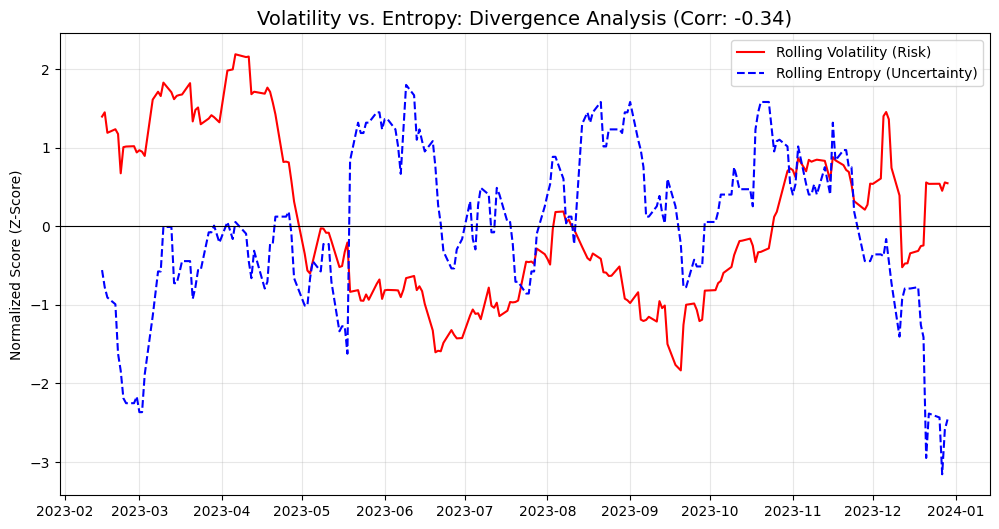

In [ ]:
# ---------------------------------------------------------
# WEEK 3: INFORMATION THEORETIC METHODS
# DAY 13: ROLLING ENTROPY VS. ROLLING VOLATILITY
# ---------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. PREPARE DATA
# ---------------------------------------------------------
ticker = "^NSEI"
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

# 2. DEFINE PARAMETERS
# ---------------------------------------------------------
window_size = 30  # 30-Day Rolling Window
num_bins = 20     # Bins for local entropy calculation

# Arrays to store results
rolling_dates = []
rolling_vol = []
rolling_ent = []

# 3. ROLLING WINDOW CALCULATION
# ---------------------------------------------------------
print("Calculated Rolling Metrics...")

# Loop through the data using a sliding window
for i in range(window_size, len(data)):
    # Slice the window (past 30 days)
    window_data = data['Log_Ret'].iloc[i-window_size : i]
    current_date = data.index[i]

    # A. Calculate Volatility (Std Dev)
    vol = window_data.std()

    # B. Calculate Entropy (Shannon)
    # We re-bin the data inside the window to measure local randomness
    counts, _ = np.histogram(window_data, bins=num_bins, density=False)
    probs = counts / np.sum(counts)
    probs = probs[probs > 0] # Remove zeros
    ent = -np.sum(probs * np.log2(probs))

    # Store
    rolling_dates.append(current_date)
    rolling_vol.append(vol)
    rolling_ent.append(ent)

# Create a DataFrame for easy plotting
df_roll = pd.DataFrame({
    'Date': rolling_dates,
    'Volatility': rolling_vol,
    'Entropy': rolling_ent
})
df_roll.set_index('Date', inplace=True)

# 4. NORMALIZE (Z-SCORE) FOR COMPARISON
# ---------------------------------------------------------
# Since Volatility is small (0.01) and Entropy is large (3.0),
# we must normalize them to compare their SHAPE.
df_roll['Z_Vol'] = stats.zscore(df_roll['Volatility'])
df_roll['Z_Ent'] = stats.zscore(df_roll['Entropy'])

# 5. STATISTICAL CORRELATION
# ---------------------------------------------------------
corr = df_roll['Volatility'].corr(df_roll['Entropy'])
print("-" * 50)
print(f"CORRELATION ANALYSIS (Window = {window_size} days)")
print("-" * 50)
print(f"Correlation between Volatility & Entropy: {corr:.4f}")

if corr > 0.8:
    print("INTERPRETATION: Strong positive relationship (Market is Normal).")
elif corr > 0.5:
    print("INTERPRETATION: Moderate relationship.")
else:
    print("INTERPRETATION: Divergence detected! Volatility and Entropy are disconnecting.")
print("-" * 50)

# 6. VISUALIZATION
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Plot normalized values
plt.plot(df_roll.index, df_roll['Z_Vol'], label='Rolling Volatility (Risk)', color='red', linewidth=1.5)
plt.plot(df_roll.index, df_roll['Z_Ent'], label='Rolling Entropy (Uncertainty)', color='blue', linestyle='--', linewidth=1.5)

plt.title(f"Volatility vs. Entropy: Divergence Analysis (Corr: {corr:.2f})", fontsize=14)
plt.ylabel("Normalized Score (Z-Score)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.axhline(0, color='black', linewidth=0.8)

plt.show()

/tmp/ipython-input-1557310064.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------
KL DIVERGENCE AUDIT (Nifty 50)
--------------------------------------------------
Observed Mean: 0.000727
Observed Vol:  0.006175
--------------------------------------------------
KL Divergence (Bits): 0.17757
--------------------------------------------------
CONCLUSION: FAILED. Significant Information Loss.
The Market is NOT Normal. (Fat Tails Detected)


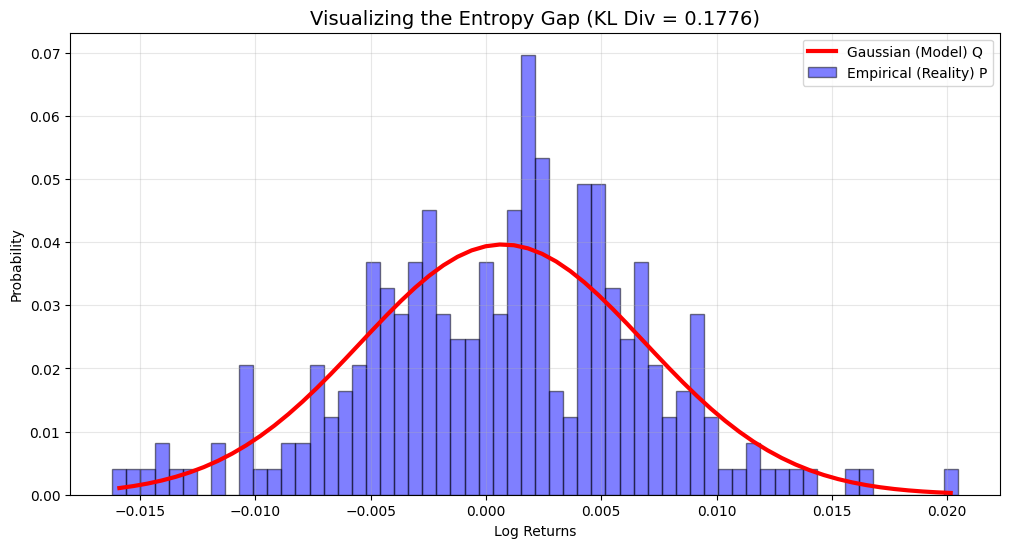

In [ ]:
# ---------------------------------------------------------
# WEEK 3: INFORMATION THEORETIC METHODS
# DAY 14: KULLBACK-LEIBLER (KL) DIVERGENCE AUDIT
# ---------------------------------------------------------

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# 1. PREPARE DATA
# ---------------------------------------------------------
ticker = "^NSEI"
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")
data['Log_Ret'] = np.log(data['Close'] / data['Close'].shift(1))
data.dropna(inplace=True)

returns = data['Log_Ret'].values
mu = np.mean(returns)
sigma = np.std(returns)

# 2. DISCRETIZATION (Create P and Q)
# ---------------------------------------------------------
# We need to bin the data to compare probabilities discrete-ly.
num_bins = 60
range_min = min(returns)
range_max = max(returns)

# A. Empirical Distribution (P) - The Reality
counts, bin_edges = np.histogram(returns, bins=num_bins, density=False)
P = counts / np.sum(counts)

# B. Theoretical Distribution (Q) - The Assumption (Normal Model)
# We calculate the Gaussian probability for the center of each bin
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
Q = stats.norm.pdf(bin_centers, mu, sigma)

# Normalize Q so it sums to 1 (like a probability mass function)
Q = Q / np.sum(Q)

# 3. CALCULATE KL DIVERGENCE
# ---------------------------------------------------------
# Formula: D_KL(P || Q) = sum( P(i) * log2( P(i) / Q(i) ) )

# Safety: Avoid division by zero or log(0)
# We only calculate where P > 0 and Q > 0
mask = (P > 0) & (Q > 0)
P_safe = P[mask]
Q_safe = Q[mask]

kl_divergence = np.sum(P_safe * np.log2(P_safe / Q_safe))

# 4. PRINT RESULTS
# ---------------------------------------------------------
print("-" * 50)
print(f"KL DIVERGENCE AUDIT (Nifty 50)")
print("-" * 50)
print(f"Observed Mean: {mu:.6f}")
print(f"Observed Vol:  {sigma:.6f}")
print("-" * 50)
print(f"KL Divergence (Bits): {kl_divergence:.5f}")
print("-" * 50)

if kl_divergence > 0.05:
    print("CONCLUSION: FAILED. Significant Information Loss.")
    print("The Market is NOT Normal. (Fat Tails Detected)")
else:
    print("CONCLUSION: PASSED. The Market is effectively Normal.")

# 5. VISUALIZATION (Visual Proof)
# ---------------------------------------------------------
plt.figure(figsize=(12, 6))

# Plot P (Reality) as bars
plt.bar(bin_centers, P, width=(bin_edges[1]-bin_edges[0]), alpha=0.5, color='blue', label='Empirical (Reality) P', edgecolor='black')

# Plot Q (Model) as a smooth line
plt.plot(bin_centers, Q, color='red', linewidth=3, label='Gaussian (Model) Q')

plt.title(f"Visualizing the Entropy Gap (KL Div = {kl_divergence:.4f})", fontsize=14)
plt.xlabel("Log Returns")
plt.ylabel("Probability")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Fetching data for ^NSEI from 2023-01-01 to 2024-01-01...
--------------------------------------------------
PROJECT DATASET READY
--------------------------------------------------
Start Price (Jan 2023):  17616.30
End Price (Dec 2023):    21731.40 (S0 for Simulation)
Current Volatility:      11.28%
Total Trading Days:      224
--------------------------------------------------


/tmp/ipython-input-737619728.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)


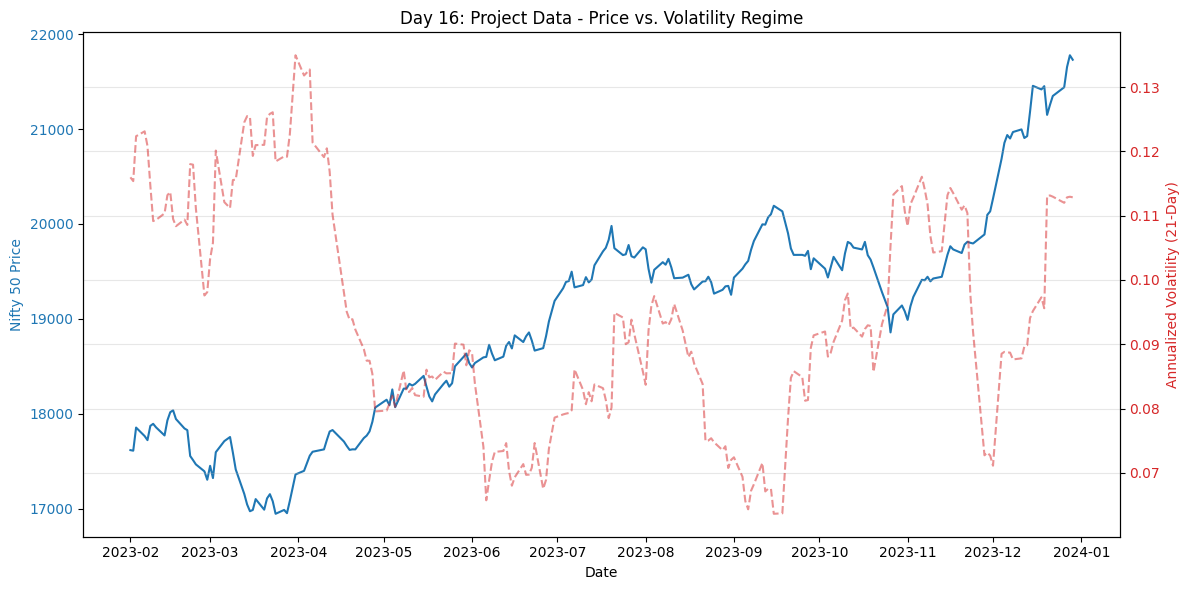

Data saved to 'nifty50_project_data.csv'.


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# --- DAY 16: PROJECT SETUP & DATA PIPELINE ---

# 1. DEFINE PARAMETERS
TICKER = '^NSEI'    # Nifty 50 Index
START_DATE = '2023-01-01'
END_DATE = '2024-01-01'
RISK_FREE_RATE = 0.07 # 7% India 10Y Bond Yield

# 2. DATA ACQUISITION
print(f"Fetching data for {TICKER} from {START_DATE} to {END_DATE}...")
data = yf.download(TICKER, start=START_DATE, end=END_DATE, progress=False)

# 3. DATA PROCESSING
df = pd.DataFrame()
df['Price'] = data['Close']

# Calculate Log Returns (The engine of our simulation)
df['Log_Return'] = np.log(df['Price'] / df['Price'].shift(1))

# Calculate Rolling Volatility (21-day trading month)
# We calculate annualized volatility for each day
df['Volatility_21d'] = df['Log_Return'].rolling(window=21).std() * np.sqrt(252)

# Drop NaN values created by rolling windows
df.dropna(inplace=True)

# 4. EXPLORATORY DATA ANALYSIS (EDA)
# We need to know the 'Last Price' and 'Current Volatility' to set up our Option pricing tomorrow
S0 = df['Price'].iloc[-1]
current_vol = df['Volatility_21d'].iloc[-1]

print("-" * 50)
print("PROJECT DATASET READY")
print("-" * 50)
print(f"Start Price (Jan 2023):  {df['Price'].iloc[0]:.2f}")
print(f"End Price (Dec 2023):    {S0:.2f} (S0 for Simulation)")
print(f"Current Volatility:      {current_vol:.2%}")
print(f"Total Trading Days:      {len(df)}")
print("-" * 50)

# 5. VISUALIZATION
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Nifty 50 Price', color=color)
ax1.plot(df.index, df['Price'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:red'
ax2.set_ylabel('Annualized Volatility (21-Day)', color=color)
ax2.plot(df.index, df['Volatility_21d'], color=color, linestyle='--', alpha=0.5)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Day 16: Project Data - Price vs. Volatility Regime')
fig.tight_layout()
plt.grid(True, alpha=0.3)
plt.savefig("day16_project_data.png")
plt.show()

# 6. SAVE DATA FOR FUTURE DAYS
df.to_csv("nifty50_project_data.csv")
print("Data saved to 'nifty50_project_data.csv'.")

--- CONTRACT DETAILS ---
Asset: Nifty 50 | Spot: 21731.40 | Strike: 21731.40
Volatility: 11.28% | Time: 1 Month

--- PRICING RESULTS ---
Monte Carlo Price:   Rs. 350.04
Black-Scholes Price: Rs. 349.29
Difference:          Rs. 0.7420

Simulated terminal prices saved to 'simulated_prices.npy'


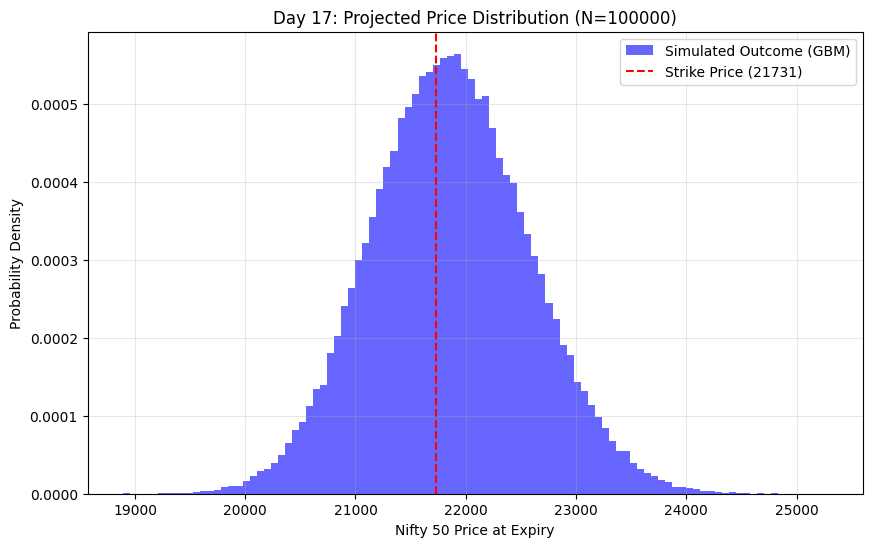

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- DAY 17: THE MONTE CARLO PRICING ENGINE ---

# 1. LOAD DATA (From Day 16)
df = pd.read_csv("nifty50_project_data.csv", index_col=0)
S0 = df['Price'].iloc[-1]       # Last observed price (Dec 2023)
sigma = df['Volatility_21d'].iloc[-1] # Last observed volatility
r = 0.07                        # Risk-Free Rate (7%)

# 2. DEFINE OPTION CONTRACT
# Let's price a "At-The-Money" (ATM) Call Option for 1 Month
K = S0                          # Strike Price = Current Price
T = 1/12                        # Time = 1 Month (0.083 years)
M = 100000                      # Number of Simulations (High precision)

print(f"--- CONTRACT DETAILS ---")
print(f"Asset: Nifty 50 | Spot: {S0:.2f} | Strike: {K:.2f}")
print(f"Volatility: {sigma:.2%} | Time: 1 Month")

# 3. RUN SIMULATION (Vectorized)
np.random.seed(42) # For reproducibility
Z = np.random.normal(0, 1, M)

# Geometric Brownian Motion Formula
# ST = S0 * exp( (r - 0.5*sigma^2)T + sigma*sqrt(T)Z )
drift = (r - 0.5 * sigma**2) * T
diffusion = sigma * np.sqrt(T) * Z
ST = S0 * np.exp(drift + diffusion)

# 4. CALCULATE PRICE
# Call Payoff = Max(ST - K, 0)
payoffs = np.maximum(ST - K, 0)
discounted_price = np.mean(payoffs) * np.exp(-r * T)

# 5. CALCULATE ANALYTICAL PRICE (Black-Scholes) FOR COMPARISON
# We need this to show the "Standard" benchmark
d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
bs_price = (S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))

# 6. RESULTS
print(f"\n--- PRICING RESULTS ---")
print(f"Monte Carlo Price:   Rs. {discounted_price:.2f}")
print(f"Black-Scholes Price: Rs. {bs_price:.2f}")
print(f"Difference:          Rs. {abs(discounted_price - bs_price):.4f}")

# 7. SAVE SIMULATION DATA FOR DAY 18
# We need the 'ST' (Terminal Prices) to measure Entropy tomorrow!
np.save("simulated_prices.npy", ST)
print("\nSimulated terminal prices saved to 'simulated_prices.npy'")

# 8. VISUALIZATION
plt.figure(figsize=(10, 6))
plt.hist(ST, bins=100, density=True, alpha=0.6, color='blue', label='Simulated Outcome (GBM)')
plt.axvline(K, color='red', linestyle='--', label=f'Strike Price ({K:.0f})')
plt.title(f'Day 17: Projected Price Distribution (N={M})')
plt.xlabel('Nifty 50 Price at Expiry')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("day17_simulation.png")
plt.show()

--- DAY 18: ENTROPY AUDIT REPORT ---
Real Market Entropy:   3.4296 bits (More Chaotic)
Model Assumed Entropy: 3.3210 bits (Too Structured)
KL Divergence (Error): 1.3589

CONCLUSION: The Real Market carries more 'Uncertainty' than the Model predicts.
The Standard Model is UNDER-ESTIMATING risk.


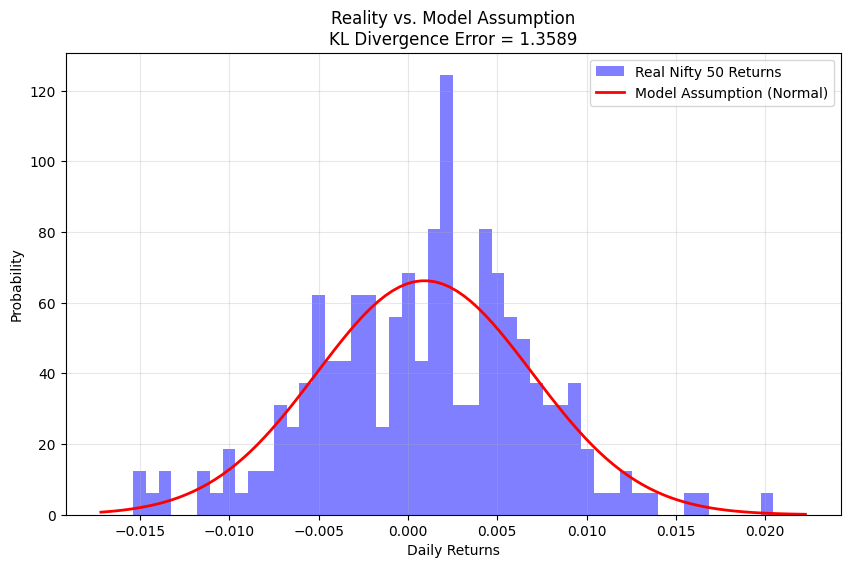

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm

# --- DAY 18: THE ENTROPY AUDIT ---

# 1. LOAD DATA
# Load Real World Data (Day 16)
df = pd.read_csv("nifty50_project_data.csv", index_col=0)
real_returns = df['Log_Return'].values

# Load Simulation Parameters (Day 17)
# We regenerate the "Model Returns" to compare apples-to-apples
mu = real_returns.mean()
sigma = real_returns.std()
M = len(real_returns) # Same number of days for fair comparison

# 2. GENERATE MODEL WORLD
# This is what the Black-Scholes model *thinks* the market looks like (Perfect Normal)
np.random.seed(42)
model_returns = np.random.normal(mu, sigma, M)

# 3. COMPUTE ENTROPY
def get_distribution_probs(data, bins=50):
    counts, bin_edges = np.histogram(data, bins=bins, density=True)
    probs = counts / np.sum(counts)
    return probs + 1e-10 # Add small epsilon to avoid log(0)

# A. Real Entropy (The Chaos of Reality)
p_real = get_distribution_probs(real_returns)
H_real = entropy(p_real)

# B. Model Entropy (The Cleanliness of Math)
p_model = get_distribution_probs(model_returns)
H_model = entropy(p_model)

# 4. COMPUTE KL DIVERGENCE (The Error Metric)
# How much information is lost if we use the Model to describe Reality?
kl_div = entropy(p_real, p_model)

# 5. RESULTS REPORT
print(f"--- DAY 18: ENTROPY AUDIT REPORT ---")
print(f"Real Market Entropy:   {H_real:.4f} bits (More Chaotic)")
print(f"Model Assumed Entropy: {H_model:.4f} bits (Too Structured)")
print(f"KL Divergence (Error): {kl_div:.4f}")

if H_real > H_model:
    print("\nCONCLUSION: The Real Market carries more 'Uncertainty' than the Model predicts.")
    print("The Standard Model is UNDER-ESTIMATING risk.")
else:
    print("\nCONCLUSION: The Model is conservative enough.")

# 6. VISUALIZATION
plt.figure(figsize=(10, 6))

# Plot Real Returns (Blue)
plt.hist(real_returns, bins=50, density=True, alpha=0.5, color='blue', label='Real Nifty 50 Returns')

# Plot Model Returns (Red Line)
# We plot the Bell Curve that Day 17 used
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2, label='Model Assumption (Normal)')

plt.title(f'Reality vs. Model Assumption\nKL Divergence Error = {kl_div:.4f}')
plt.xlabel('Daily Returns')
plt.ylabel('Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("day18_entropy_audit.png")
plt.show()

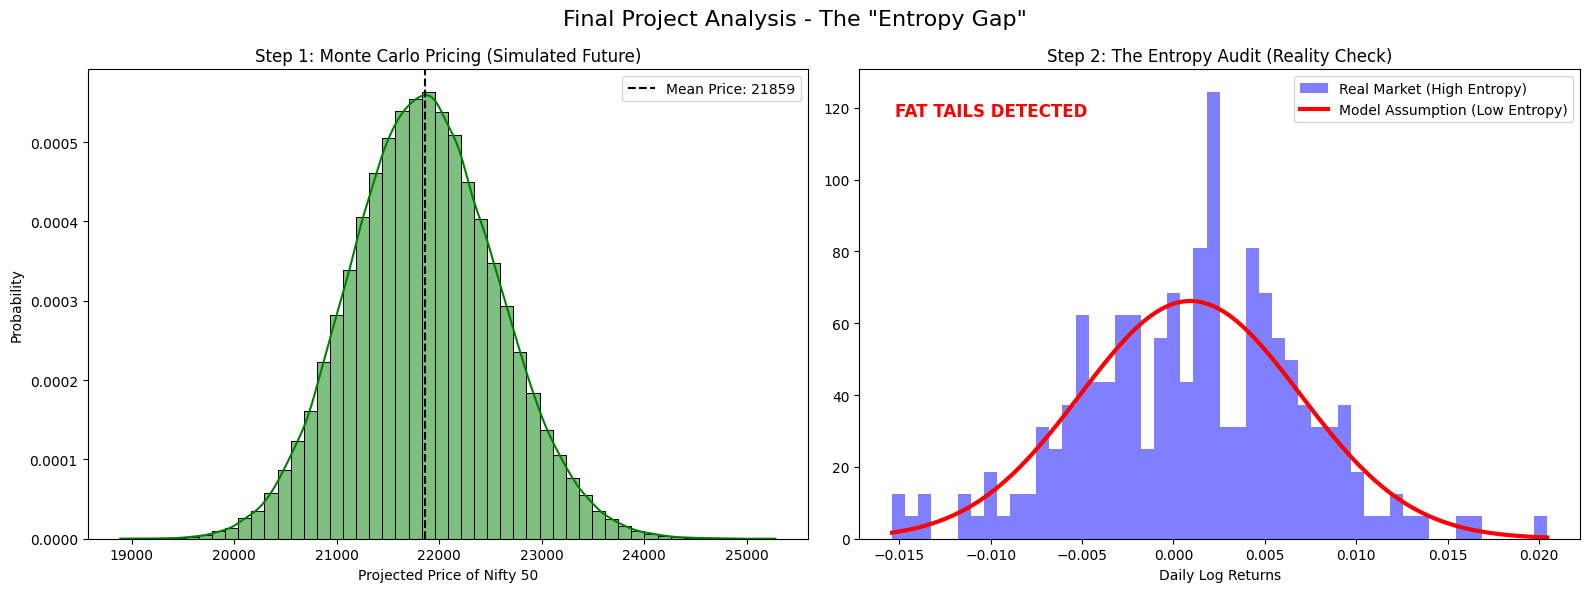

Final Master Plot generated. Use 'day19_master_plot.png' in your report.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

# --- DAY 19: FINAL INTEGRATED VISUALIZATION ---

# 1. LOAD DATA (From previous days)
df = pd.read_csv("nifty50_project_data.csv", index_col=0)
real_returns = df['Log_Return'].values
sim_prices = np.load("simulated_prices.npy") # From Day 17

# 2. SETUP THE MASTER PLOT
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Final Project Analysis - The "Entropy Gap"', fontsize=16)

# --- LEFT PANEL: THE PRICING MODEL (Day 17) ---
# This shows the "Future" according to Monte Carlo
sns.histplot(sim_prices, bins=50, kde=True, color='green', ax=ax1, stat='density')
ax1.set_title('Step 1: Monte Carlo Pricing (Simulated Future)')
ax1.set_xlabel('Projected Price of Nifty 50')
ax1.set_ylabel('Probability')
ax1.axvline(np.mean(sim_prices), color='black', linestyle='--', label=f'Mean Price: {np.mean(sim_prices):.0f}')
ax1.legend()

# --- RIGHT PANEL: THE ENTROPY AUDIT (Day 18) ---
# This shows the "Error" in the model's assumptions
mu, sigma = real_returns.mean(), real_returns.std()
x = np.linspace(real_returns.min(), real_returns.max(), 100)
pdf_model = norm.pdf(x, mu, sigma)

# Plot Reality (Blue)
ax2.hist(real_returns, bins=50, density=True, alpha=0.5, color='blue', label='Real Market (High Entropy)')
# Plot Model (Red)
ax2.plot(x, pdf_model, 'r-', linewidth=3, label='Model Assumption (Low Entropy)')

ax2.set_title('Step 2: The Entropy Audit (Reality Check)')
ax2.set_xlabel('Daily Log Returns')
ax2.legend()
ax2.text(0.05, 0.9, "FAT TAILS DETECTED", transform=ax2.transAxes, color='red', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("day19_master_plot.png")
plt.show()

print("Final Master Plot generated. Use 'day19_master_plot.png' in your report.")